# Modelo predictivo  (Espacial) de siniestros en las calles de Santiago
- UDD - MDS18 - BDA
- Final Delivery 
- 20_Final_Geo_Project_Dynamic_features
- 09 August 2019

**CHANGE KERNEL:** geo_p_3_7

## Datasets (Landing)

###  CONASET
http://mapas-conaset.opendata.arcgis.com/search?groupIds=fca1f61c6556499db843c09cc80c70c0

Estas capas contienen la geocodificación de los accidentes de tránsito registrados en la Región Metropolitana entre los años 2013 y 2018. Contiene los detalles de fecha (en la mayoria solo día/mes), tipo de accidente, causa basal del accidente, dirección donde ocurrió el accidente, fallecidos y lesionados según gravedad. 
- [Siniestros RM - 2013](http://mapas-conaset.opendata.arcgis.com/datasets/12cb58c27a2846dfa60cf629a14d611a_0)
- [Siniestros RM - 2014](http://mapas-conaset.opendata.arcgis.com/datasets/aa5b5322bc564b809aa29c70658b9cf9_0)
- [Siniestros RM - 2015](http://mapas-conaset.opendata.arcgis.com/datasets/dafa26dbce99467985596d8a58216b79_0)
- [Siniestros RM - 2016](http://mapas-conaset.opendata.arcgis.com/datasets/32ee49c703b840b885b9c80b37ae72d0_0)
- [Siniestros RM - 2017](http://mapas-conaset.opendata.arcgis.com/datasets/907addac92b74e3fa30d40edb72d1813_0)
- [Siniestros RM - 2018](http://mapas-conaset.opendata.arcgis.com/datasets/3a084373b58b45d0ae01d9c14a231cf8_0)

`Year Columns order are different. Need to be corrected before be concatenated` 

### OpenStreetMap
- POI and streets of Santiago
<br><br>
http://download.geofabrik.de/south-america/chile.html

## Main Libraries

In [1]:
from math import radians, cos, sin, asin, sqrt, atan2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
import seaborn as sns
import folium
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, MultiLineString
import shapefile as shp
import gpd_lite_toolbox as glt
from gpd_lite_toolbox.utils_carto import m_plot_dataframe, m_plot_multipolygon
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(context='paper', style='ticks', palette='inferno')
sns.mpl.rc("figure", figsize=(10, 6))
mpl.rcParams['figure.dpi']= 150

## Main Functions

In [3]:
def intersection(municipality, urban_area):
    return municipality.intersection(urban_area)

In [4]:
def urban_part(municipality):
    return intersection(municipality, stgo)

## Getting Raw Data

### Loading data from CONASET

In [5]:
ls ../data/CONASET

SiniestrosRM2013/   SiniestrosRM2015/   SiniestrosRM2017/   SiniestrosRM2018_2/
SiniestrosRM2014/   SiniestrosRM2016/   SiniestrosRM2018/


In [6]:
df_2018 = gpd.read_file("../data/CONASET/SiniestrosRM2018_2/SiniestrosRM2018.shp", encoding='utf-8', crs={'init': 'epsg:4326'})
df_2018.shape

(23939, 45)

In [7]:
df_2017 = gpd.read_file("../data/CONASET/SiniestrosRM2017/SiniestrosRM2017.shp", encoding='utf-8', crs={'init': 'epsg:4326'})
df_2017.shape

(25567, 46)

In [8]:
df_2016 = gpd.read_file("../data/CONASET/SiniestrosRM2016/SiniestrosRM2016.shp", encoding='utf-8', crs={'init': 'epsg:4326'})
df_2016.shape

(22441, 45)

In [9]:
df_2015 = gpd.read_file("../data/CONASET/SiniestrosRM2015/SiniestrosRM2015.shp", encoding='utf-8', crs={'init': 'epsg:4326'})
df_2015.shape

(19271, 28)

In [10]:
df_2014 = gpd.read_file("../data/CONASET/SiniestrosRM2014/SiniestrosRM2014.shp", crs={'init': 'epsg:4326'})
df_2014.shape

(18577, 55)

In [11]:
df_2013 = gpd.read_file("../data/CONASET/SiniestrosRM2013/SiniestrosRM2013.shp", crs={'init': 'epsg:4326'})
df_2013.shape

(19983, 68)

In [12]:
p0 = Point(0,0)

In [13]:
(df_2018['geometry'] == p0).sum()

3537

In [14]:
s_2018 = df_2018[df_2018['geometry'] != p0]

In [15]:
s_2018.shape

(20402, 45)

In [16]:
df_2017['Ano'] = 2017

In [17]:
df_2016['Ano'] = 2016

In [18]:
df_2015['Ano'] = 2015

In [19]:
df_2014['Ano'] = 2014

In [20]:
df_2013['Ano'] = 2013

In [21]:
s_2018 = s_2018[['geometry', 'Ano', 'Tipo_CONAS', 'Fallecidos', 'Graves', 'Menos_Grav', 'Leves']]

In [22]:
s_2017 = df_2017[['geometry', 'Ano', 'Tipo__CONA', 'Fallecidos', 'Graves', 'Menos_Grav', 'Leves']]

In [23]:
s_2016 = df_2016[['geometry', 'Ano', 'Tipo__CONA', 'Fallecidos', 'Graves', 'Menos_Grav', 'Leves']]

In [24]:
s_2015 = df_2015[['geometry', 'Ano', 'Tipo_CON', 'Fallecido', 'Grave', 'MGrave', 'Leve']]

In [25]:
s_2014 = df_2014[['geometry', 'Ano', 'Tipo__CONA', 'Fallecidos', 'Graves', 'Menos_Grav', 'Leves']]

In [26]:
s_2013 = df_2013[['geometry', 'Ano', 'Tipo__CONA', 'Fallecidos', 'Graves', 'Menos_Grav', 'Leves']]

In [27]:
s_2018.columns = ['geometry', 'Ano', 'Tipo__CONA', 'Fallecidos', 'Graves', 'Menos_Grav', 'Leves']

In [28]:
s_2017.columns = ['geometry', 'Ano', 'Tipo__CONA', 'Fallecidos', 'Graves', 'Menos_Grav', 'Leves']

In [29]:
s_2016.columns = ['geometry', 'Ano', 'Tipo__CONA', 'Fallecidos', 'Graves', 'Menos_Grav', 'Leves']

In [30]:
s_2015.columns = ['geometry', 'Ano', 'Tipo__CONA', 'Fallecidos', 'Graves', 'Menos_Grav', 'Leves']

In [31]:
s_2014.columns = ['geometry', 'Ano', 'Tipo__CONA', 'Fallecidos', 'Graves', 'Menos_Grav', 'Leves']

In [32]:
s_2013.columns = ['geometry', 'Ano', 'Tipo__CONA', 'Fallecidos', 'Graves', 'Menos_Grav', 'Leves']

In [33]:
df = gpd.GeoDataFrame(pd.concat([s_2013, s_2014,s_2015,s_2016,s_2017,s_2018], ignore_index=True), crs='4326')

In [34]:
(df.geometry.type !='Point').sum()

1462

In [35]:
df = df[df['geometry'].type =='Point']

In [36]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 124779 entries, 0 to 126240
Data columns (total 7 columns):
geometry      124779 non-null object
Ano           124779 non-null int64
Tipo__CONA    124779 non-null object
Fallecidos    124779 non-null int64
Graves        124779 non-null int64
Menos_Grav    124779 non-null int64
Leves         124779 non-null int64
dtypes: int64(5), object(2)
memory usage: 7.6+ MB


In [37]:
df.shape

(124779, 7)

In [38]:
df.Tipo__CONA.value_counts()

COLISION     77528
CHOQUE       25816
ATROPELLO    13388
CAIDA         3397
OTRO TIPO     2537
VOLCADURA     2091
INCENDIO        22
Name: Tipo__CONA, dtype: int64

In [39]:
df.Fallecidos.value_counts()

0    123444
1      1277
2        50
3         7
4         1
Name: Fallecidos, dtype: int64

In [40]:
df.Graves.value_counts()

0    114531
1      9769
2       415
3        43
4        14
5         4
7         2
6         1
Name: Graves, dtype: int64

In [41]:
df.Menos_Grav.value_counts()

0    120682
1      3894
2       177
3        21
4         4
8         1
Name: Menos_Grav, dtype: int64

In [42]:
df.Leves.value_counts()

0     84718
1     31544
2      6442
3      1287
4       449
5       186
6        61
7        31
8        16
9        13
11        6
13        6
12        4
14        3
24        2
10        2
19        2
15        1
16        1
18        1
21        1
22        1
23        1
26        1
Name: Leves, dtype: int64

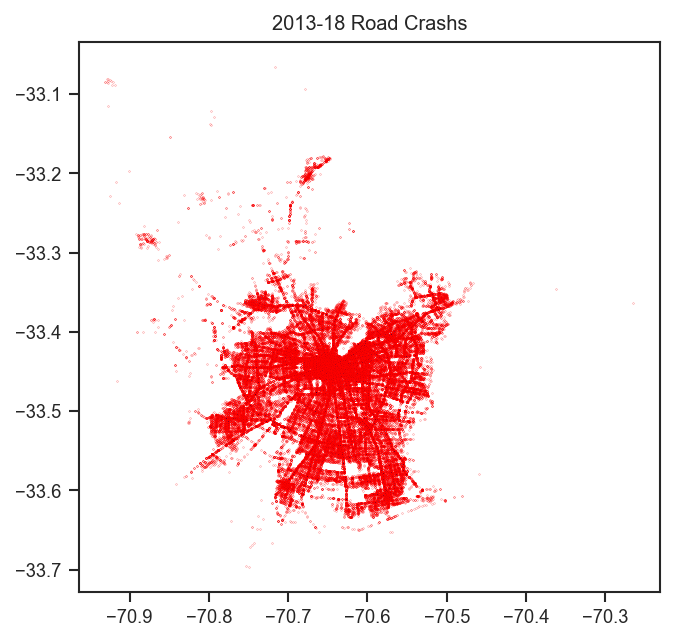

In [43]:
df.plot(markersize=0.01, edgecolor='red',figsize=(5, 5));
plt.title("2013-18 Road Crashs");

In [45]:
df.crs = {'init' :'epsg:4326'}

In [46]:
df.to_file("../data/CONASET/RM_Crashes_2013_2018/Crashes_2013_2018_dataset.shp")

### Restrict Siniestros inside Santiago Municipality Area

In [47]:
urban_areas = gpd.read_file('../data/OSM_Chile/urban_areas/',
                            crs={'init': 'epsg:5361'})
municipalities = gpd.read_file(
    '../data/OSM_Chile/shapefile_comunas/division_comunal.shp',
    crs={'init': 'epsg:5361'})
stgo_municipalities = gpd.sjoin(municipalities,
                                urban_areas[urban_areas.NOMBRE == 'Santiago'],
                                op='intersects')
stgo = urban_areas[urban_areas.NOMBRE == 'Santiago'].geometry.values[0]
stgo_shape = urban_areas[urban_areas.NOMBRE == 'Santiago'].to_crs(
    {'init': 'epsg:4326'})

In [48]:
stgo_shape

,NOMBRE,TIPO_AREA,SHAPE_Leng,SHAPE_Area,geometry
385,Santiago,Ciudad,427491.444262,5.821041e+08,(POLYGON ((-70.73662882538488 -33.371762170851...


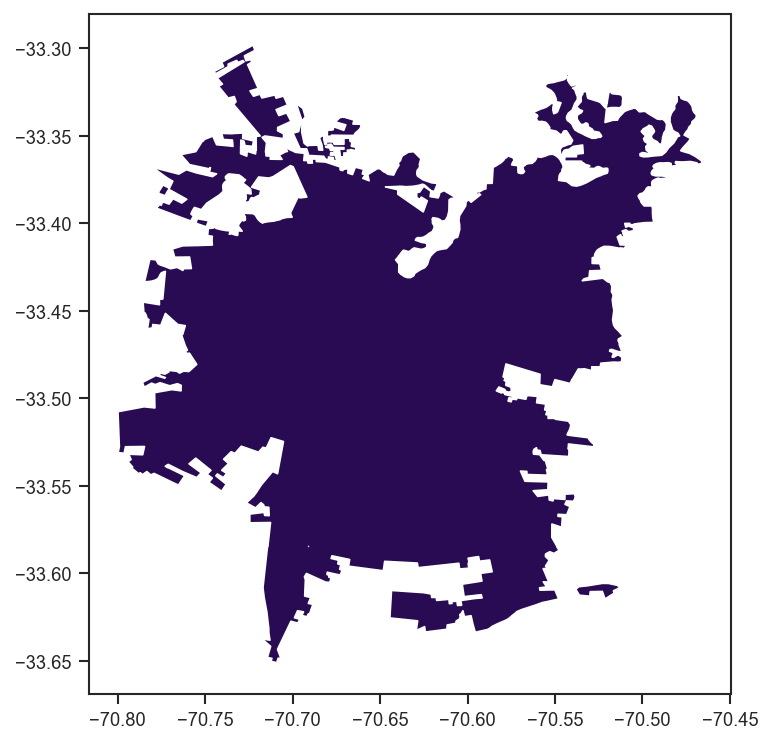

In [49]:
stgo_shape.plot()

In [50]:
# Comuna of Santiago used for test only 
com_stgo = municipalities[municipalities.NOM_COM == 'Santiago'].to_crs(
    {'init': 'epsg:4326'})

In [51]:
com_stgo

,NOM_REG,NOM_PROV,NOM_COM,SHAPE_LENG,DIS_ELEC,CIR_SENA,COD_COMUNA,SHAPE_Le_1,SHAPE_Area,geometry
305,Región Metropolitana de Santiago,Santiago,Santiago,24644.018619,22,7,1310,22142.660056,2.276999e+07,POLYGON ((-70.67158854755513 -33.4763598849684...


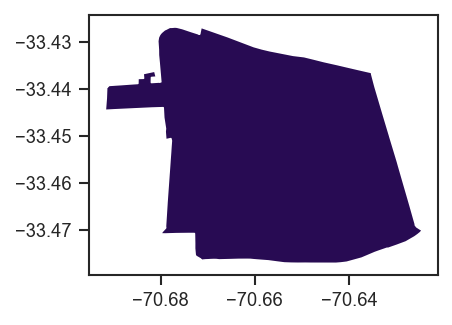

In [52]:
com_stgo.plot(figsize=(3, 3))

In [53]:
type(df.geometry)

geopandas.geoseries.GeoSeries

In [54]:
siniestros = gpd.sjoin(df, stgo_shape, op='intersects')

In [55]:
siniestros.shape

(120042, 12)

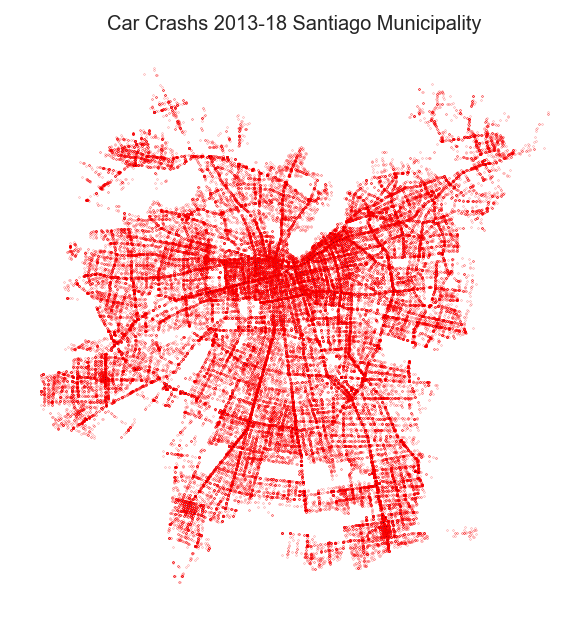

In [56]:
siniestros.plot(markersize=0.01, edgecolor='red',figsize=(5, 5));
plt.axis('off');
plt.title("Car Crashs 2013-18 Santiago Municipality");

In [57]:
siniestros.head(2)

,geometry,Ano,Tipo__CONA,Fallecidos,Graves,Menos_Grav,Leves,index_right,NOMBRE,TIPO_AREA,SHAPE_Leng,SHAPE_Area
0,POINT (-70.6264627040905 -33.43363955092453),2013,ATROPELLO,0,0,0,1,385,Santiago,Ciudad,427491.444262,5.821041e+08
1,POINT (-70.6792097614213 -33.36821861599628),2013,CHOQUE,0,0,0,0,385,Santiago,Ciudad,427491.444262,5.821041e+08


In [58]:
del siniestros['index_right']
del siniestros['NOMBRE']
del siniestros['TIPO_AREA']
del siniestros['SHAPE_Leng']
del siniestros['SHAPE_Area']

In [59]:
siniestros.sample(10)

,geometry,Ano,Tipo__CONA,Fallecidos,Graves,Menos_Grav,Leves
35481,POINT (-70.648046619512 -33.43345860695425),2014,COLISION,0,0,0,0
15675,POINT (-70.63825480631419 -33.4315262178606),2013,COLISION,0,0,0,0
6505,POINT (-70.64326859417025 -33.45835107983841),2013,COLISION,0,0,0,0
84817,POINT (-70.6948968 -33.3656223),2017,COLISION,0,0,0,0
50864,POINT (-70.71238180575608 -33.42689026943366),2015,COLISION,0,0,0,0
34083,POINT (-70.60146855730427 -33.41822751457453),2014,CAIDA,0,0,0,1
51177,POINT (-70.69056307345224 -33.57414370827334),2015,COLISION,0,0,0,1
43973,POINT (-70.55386216428418 -33.42418513977575),2015,COLISION,0,0,0,0
101215,POINT (-70.65372489250157 -33.49941732204336),2017,ATROPELLO,1,0,0,0
72930,POINT (-70.60143310372905 -33.47938940480375),2016,COLISION,0,0,0,0


### Adding Crash Severity

`Severity of a Crash Definition:`
"The severity of a crash. Possible values are 'F' (Fallecidos), 'G' (Grave), 'M' (Menos Grave),  'L' (Leves), 'N' (non-injury). This is determined by the worst injury sustained in the crash at time of entry."

In [60]:
def sev_crash(row):
    if row['Fallecidos'] != 0: return 'F'
    elif row['Graves'] !=0: return'G'
    elif row['Menos_Grav'] !=0: return 'M'
    elif row['Leves'] !=0: return 'L'
    else: return 'N'

In [61]:
siniestros['SEV'] = siniestros.apply(sev_crash, axis=1)

Creating a new Column Serverity Index

In [62]:
def sev_index_crash(row):
    if row['Fallecidos'] != 0: return 5
    elif row['Graves'] !=0: return 4
    elif row['Menos_Grav'] !=0: return 3
    elif row['Leves'] !=0: return 2
    else: return 1

In [63]:
siniestros['SEV_Index'] = siniestros.apply(sev_index_crash, axis=1)

In [64]:
siniestros.SEV.value_counts()

N    69617
L    35766
G     9745
M     3644
F     1270
Name: SEV, dtype: int64

In [65]:
siniestros.SEV_Index.value_counts()

1    69617
2    35766
4     9745
3     3644
5     1270
Name: SEV_Index, dtype: int64

In [66]:
siniestros.Tipo__CONA.value_counts()

COLISION     74563
CHOQUE       24759
ATROPELLO    12986
CAIDA         3338
OTRO TIPO     2449
VOLCADURA     1925
INCENDIO        22
Name: Tipo__CONA, dtype: int64

In [67]:
siniestros.to_file("../data/CONASET/STGO_Crashes_2013_2018/Crashes_Stgo_2013_2018_dataset.shp")

---

## Filter crash type per year

In [64]:
def filter_tipo_year(s, Y, D1, D2):
    s = s[(s.Ano >= D1) & (s.Ano <= D2)]
    s = s[s.Tipo__CONA == Y]
    return s[['geometry']]

In [65]:
D1 = 2013
D2 = 2018
Y = 'COLISION'

In [66]:
s = filter_tipo_year(siniestros, Y, D1, D2)

In [67]:
s.sample(5)

,geometry
53527,POINT (-70.71536961946299 -33.47637651241219)
101562,POINT (-70.69053247214701 -33.57414151286049)
30576,POINT (-70.60027955028217 -33.58185225456057)
72501,POINT (-70.61432724088765 -33.44483533955382)
56044,POINT (-70.74722236202996 -33.51038928109519)


In [68]:
len(s.geometry)

74563

## Adding Crash related features to grid

In [69]:
!ls ../data/OSM_Chile/grid/*.shp

../data/OSM_Chile/grid/geo_stgo_100_crash_test_dataset.shp
../data/OSM_Chile/grid/geo_stgo_100_crash_train_dataset.shp
../data/OSM_Chile/grid/geo_stgo_100_estatic_dataset.shp
../data/OSM_Chile/grid/stgo_grid_100m.shp
../data/OSM_Chile/grid/stgo_grid_50m.shp
../data/OSM_Chile/grid/stgo_grid_50m_.shp
../data/OSM_Chile/grid/stgo_grid_to_roads_100m.shp
../data/OSM_Chile/grid/stgo_grid_to_roads_50m.shp


In [74]:
grid_path = "../data/OSM_Chile/grid/stgo_grid_to_roads_100m.shp"
grid = gpd.read_file(grid_path, encoding='utf-8', crs={'init': 'epsg:4326'})
grid.shape

(63029, 2)

In [71]:
grid.head()

,FID,geometry
0,0,POLYGON ((-70.8251902322438 -33.55724198234194...
1,1,POLYGON ((-70.82428525910399 -33.5563328914328...
2,2,POLYGON ((-70.82428525910399 -33.5572419823419...
3,3,POLYGON ((-70.8233761681949 -33.55633289143285...
4,4,POLYGON ((-70.8233761681949 -33.55724198234194...


### Defining a generic Function to add a crash event by type and date range to the grid

In [68]:
def adding_sin_type_date_to_grid(g, s, Y, D1, D2):
    s = s[(s.Ano >= D1) & (s.Ano <= D2)]
    s = s[s.Tipo__CONA == Y]
    size = len(s)
    s = s[['geometry']].copy()
    s = gpd.sjoin(g, s, how='left', op='intersects')
    s = s.fillna(0)
    s = s.rename(columns={'index_right': Y})
    s[Y] = s[Y].apply(lambda x: 0 if x == 0.0 else 1)
    gs = s.groupby('FID', as_index=False).agg({
        Y: 'sum',
        'geometry': 'first'
    })
    gs = gpd.GeoDataFrame(gs, crs='4326')
    print("Grid shape: ", gs.shape)
    print("Crash type {} has {} events".format(Y, gs[Y].sum()))
    print(" - {} events not capured on grid".format(size - gs[Y].sum()))
    return gs

## Define Features from 2013 to 2017 to be used as Train

In [73]:
D1 = 2013
D2 = 2017

In [74]:
Y = 'COLISION'
COLISION = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type COLISION has 62616 events
 - 635 events not capured on grid


In [75]:
Y = 'CHOQUE'
CHOQUE = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type CHOQUE has 19903 events
 - 278 events not capured on grid


In [76]:
Y = 'ATROPELLO'
ATROPELLO = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type ATROPELLO has 10999 events
 - 70 events not capured on grid


In [77]:
Y = 'OTRO TIPO'
OTRO_TIPO = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type OTRO TIPO has 1925 events
 - 25 events not capured on grid


In [78]:
Y = 'CAIDA'
CAIDA = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type CAIDA has 2868 events
 - 21 events not capured on grid


In [79]:
Y = 'VOLCADURA'
VOLCADURA = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type VOLCADURA has 1390 events
 - 18 events not capured on grid


In [80]:
Y = 'INCENDIO'
INCENDIO = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type INCENDIO has 18 events
 - 0 events not capured on grid


### Defining Crash Type Buffer 

In [81]:
D1 = 2013
D2 = 2017
meters = 200
g = grid
Y = 'INCENDIO'

In [82]:
s = siniestros[(siniestros.Ano >= D1) & (siniestros.Ano <= D2)]

In [83]:
s = s[s.Tipo__CONA == Y]
size = len(s)

In [84]:
s = s[['geometry']].copy()

In [85]:
s.head(10)

,geometry
7271,POINT (-70.66162919982764 -33.48141739979316)
15502,POINT (-70.60784355683467 -33.5352836553164)
33163,POINT (-70.67026881178782 -33.45175553260719)
36098,POINT (-70.6892913791101 -33.36658428020854)
41710,POINT (-70.64829877821325 -33.56033034357485)
51819,POINT (-70.66704885794493 -33.43103241911675)
52396,POINT (-70.67392671786273 -33.44281676888118)
52789,POINT (-70.52963623984905 -33.42013078749365)
69226,POINT (-70.527852 -33.46649020000002)
70377,POINT (-70.56839816854708 -33.54753778839526)


In [86]:
dist = (meters*0.1)/11000
s['geometry']= s.geometry.buffer(dist)

In [87]:
s.head(10)

,geometry
7271,POLYGON ((-70.65981101800946 -33.4814173997931...
15502,POLYGON ((-70.60602537501649 -33.5352836553164...
33163,POLYGON ((-70.66845062996964 -33.4517555326071...
36098,POLYGON ((-70.68747319729192 -33.3665842802085...
41710,POLYGON ((-70.64648059639507 -33.5603303435748...
51819,POLYGON ((-70.66523067612675 -33.4310324191167...
52396,POLYGON ((-70.67210853604455 -33.4428167688811...
52789,POLYGON ((-70.52781805803087 -33.4201307874936...
69226,POLYGON ((-70.52603381818182 -33.4664902000000...
70377,POLYGON ((-70.5665799867289 -33.54753778839526...


In [88]:
# sb = gpd.GeoDataFrame(sb, crs='4326')

In [89]:
s = gpd.sjoin(g, s, how='left', op='intersects')

In [90]:
s.head()

,FID,geometry,index_right
0,0,POLYGON ((-70.8251902322438 -33.55724198234194...,NaN
1,1,POLYGON ((-70.82428525910399 -33.5563328914328...,NaN
2,2,POLYGON ((-70.82428525910399 -33.5572419823419...,NaN
3,3,POLYGON ((-70.8233761681949 -33.55633289143285...,NaN
4,4,POLYGON ((-70.8233761681949 -33.55724198234194...,NaN


In [91]:
s = s.fillna(0)

In [92]:
s.index_right.value_counts()

0.0        62701
7271.0        22
91597.0       22
91598.0       22
41710.0       22
98239.0       22
52396.0       22
36098.0       22
72466.0       22
51819.0       20
93487.0       20
15502.0       20
33163.0       20
85836.0       20
94432.0       18
52789.0       17
69226.0       16
70377.0       15
71010.0       15
Name: index_right, dtype: int64

In [93]:
Y = Y+'_'+str(meters)

In [94]:
s = s.rename(columns={'index_right': Y})

In [95]:
s.head(2)

,FID,geometry,INCENDIO_200
0,0,POLYGON ((-70.8251902322438 -33.55724198234194...,0.0
1,1,POLYGON ((-70.82428525910399 -33.5563328914328...,0.0


In [96]:
s[Y] = s[Y].apply(lambda x: 0 if x == 0.0 else 1)

In [97]:
gs = s.groupby('FID', as_index=False).agg({
    Y: 'sum',
    'geometry': 'first'
})
gs = gpd.GeoDataFrame(gs, crs='4326')

In [98]:
print("Grid shape: ", gs.shape)
print("Crash type {} has {} events".format(Y, gs[Y].sum()))

Grid shape:  (63029, 3)
Crash type INCENDIO_200 has 357 events


### Defining a generic Function to add a crash event by type, distance in meters and date range to the grid

In [69]:
def adding_sin_type_date_dist_to_grid(g, s, Y, D1, D2, meters): 
    s = s[(s.Ano >= D1) & (s.Ano <= D2)]
    s = s[s.Tipo__CONA == Y]
    s = s[['geometry']].copy()
    dist = (meters*0.1)/11000
    s['geometry']= s.geometry.buffer(dist)
    s = gpd.sjoin(g, s, how='left', op='intersects')
    s = s.fillna(0)
    Y = Y+'_'+str(meters)
    s = s.rename(columns={'index_right': Y})
    s[Y] = s[Y].apply(lambda x: 0 if x == 0.0 else 1)
    gs = s.groupby('FID', as_index=False).agg({
        Y: 'sum',
        'geometry': 'first'
    })
    gs = gpd.GeoDataFrame(gs, crs='4326')
    print("Grid shape: ", gs.shape)
    print("Crash type {} has {} events".format(Y, gs[Y].sum()))
    return gs

In [100]:
D1 = 2013
D2 = 2017

In [101]:
meters = 200
Y = 'INCENDIO'

In [102]:
INCENDIO_200 = adding_sin_type_date_dist_to_grid(grid, siniestros, Y, D1, D2,
                                                 meters)

Grid shape:  (63029, 3)
Crash type INCENDIO_200 has 357 events


In [103]:
meters = 100

In [104]:
INCENDIO_100 = adding_sin_type_date_dist_to_grid(grid, siniestros, Y, D1, D2,
                                                 meters)

Grid shape:  (63029, 3)
Crash type INCENDIO_100 has 138 events


In [105]:
meters = 1

In [106]:
INCENDIO_1 = adding_sin_type_date_dist_to_grid(grid, siniestros, Y, D1, D2,
                                               meters)

Grid shape:  (63029, 3)
Crash type INCENDIO_1 has 18 events


In [107]:
ATROPELLO_100 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'ATROPELLO', D1, D2, 100)
ATROPELLO_200 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'ATROPELLO', D1, D2, 200)

Grid shape:  (63029, 3)
Crash type ATROPELLO_100 has 85267 events
Grid shape:  (63029, 3)
Crash type ATROPELLO_200 has 221778 events


In [108]:
CAIDA_100 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'CAIDA', D1, D2, 100)
CAIDA_200 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'CAIDA', D1, D2, 200)

Grid shape:  (63029, 3)
Crash type CAIDA_100 has 22165 events
Grid shape:  (63029, 3)
Crash type CAIDA_200 has 57587 events


In [109]:
COLISION_100 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'COLISION', D1, D2, 100)
COLISION_200 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'COLISION', D1, D2, 200)

Grid shape:  (63029, 3)
Crash type COLISION_100 has 484477 events
Grid shape:  (63029, 3)
Crash type COLISION_200 has 1254630 events


In [110]:
OTRO_TIPO_100 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'OTRO TIPO', D1, D2, 100)
OTRO_TIPO_200 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'OTRO TIPO', D1, D2, 200)

Grid shape:  (63029, 3)
Crash type OTRO TIPO_100 has 14835 events
Grid shape:  (63029, 3)
Crash type OTRO TIPO_200 has 38544 events


In [111]:
VOLCADURA_100 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'VOLCADURA', D1, D2, 100)
VOLCADURA_200 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'VOLCADURA', D1, D2, 200)

Grid shape:  (63029, 3)
Crash type VOLCADURA_100 has 10647 events
Grid shape:  (63029, 3)
Crash type VOLCADURA_200 has 27364 events


In [112]:
CHOQUE_100 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'CHOQUE', D1, D2, 100)
CHOQUE_200 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'CHOQUE', D1, D2, 200)

Grid shape:  (63029, 3)
Crash type CHOQUE_100 has 153468 events
Grid shape:  (63029, 3)
Crash type CHOQUE_200 has 397368 events


### Defining a generic Function to add a crash dinamic features and date range to the grid

In [113]:
D1 = 2013
D2 = 2017
Feature = 'SEV_Index'

In [114]:
siniestros[Feature].value_counts()

1    69617
2    35766
4     9745
3     3644
5     1270
Name: SEV_Index, dtype: int64

In [115]:
s = siniestros[(siniestros.Ano >= D1) & (siniestros.Ano <= D2)]

In [116]:
s = s[['geometry', Feature]].copy()

In [117]:
s = gpd.sjoin(grid, s, how='left', op='intersects')

In [118]:
s = s.fillna(0)

In [119]:
s.head(2)

,FID,geometry,index_right,SEV_Index
0,0,POLYGON ((-70.8251902322438 -33.55724198234194...,0.0,0.0
1,1,POLYGON ((-70.82428525910399 -33.5563328914328...,0.0,0.0


In [120]:
del s['index_right']

In [121]:
gs = s.groupby('FID', as_index=False).agg({
    Feature: 'mean',
    'geometry': 'first'
})

In [122]:
gs = gpd.GeoDataFrame(gs, crs='4326')

In [123]:
gs.head(2)

,FID,SEV_Index,geometry
0,0,0.0,POLYGON ((-70.8251902322438 -33.55724198234194...
1,1,0.0,POLYGON ((-70.82428525910399 -33.5563328914328...


In [124]:
gs.SEV_Index.round().value_counts()

0.0    42309
1.0     9678
2.0     9196
3.0      899
4.0      815
5.0      132
Name: SEV_Index, dtype: int64

In [125]:
severity = gs

**Defining a generic Function to add a crash dinamic features and date range to the grid** 

In [70]:
def adding_din_feat_date_dist_to_grid(g, s, Feature, D1, D2, meters, agg_type='sum'): 
    s = s[(s.Ano >= D1) & (s.Ano <= D2)]
    s = s[['geometry', Feature]].copy()
    dist = (meters*0.1)/11000
    s['geometry']= s.geometry.buffer(dist)
    s = gpd.sjoin(g, s, how='left', op='intersects')
    s = s.fillna(0)
    Y = Feature+'_'+str(meters)
    s = s.rename(columns={'index_right': Y})
    s[Y] = s[Y].apply(lambda x: 0 if x == 0.0 else 1)
    gs = s.groupby('FID', as_index=False).agg({
        Y: agg_type,
        'geometry': 'first'
    })
    gs = gpd.GeoDataFrame(gs, crs='4326')
    print("Grid shape: ", gs.shape)
    print("Crash type {} has {} events".format(Y, round(gs[Y].sum())))
    return gs

In [127]:
D1 = 2013
D2 = 2017
Feature = 'SEV_Index'
sever_idx = adding_din_feat_date_dist_to_grid(grid, siniestros, Feature, D1, D2, 1, agg_type='mean')

Grid shape:  (63029, 3)
Crash type SEV_Index_1 has 21332.0 events


In [128]:
sever_idx_100 = adding_din_feat_date_dist_to_grid(grid, siniestros, Feature, D1, D2, 100, agg_type='mean')

Grid shape:  (63029, 3)
Crash type SEV_Index_100 has 51908.0 events


In [129]:
sever_idx_200 = adding_din_feat_date_dist_to_grid(grid, siniestros, Feature, D1, D2, 200, agg_type='mean')

Grid shape:  (63029, 3)
Crash type SEV_Index_200 has 57634.0 events


## Creating a Train dataset

In [71]:
def concat_dataset(df1, df2):
    data = pd.concat([df1, df2], axis = 1)
    _, i = np.unique(data.columns, return_index=True)
    data = data.iloc[:, i]
    return data

**Adding Centroid features**

In [131]:
data = grid.copy()

In [132]:
data["X"] = data.centroid.x
data["Y"] = data.centroid.y
data.head(2)

,FID,geometry,X,Y
0,0,POLYGON ((-70.8251902322438 -33.55724198234194...,-70.824738,-33.557697
1,1,POLYGON ((-70.82428525910399 -33.5563328914328...,-70.823831,-33.556787


**Adding dynamic features**

In [133]:
data = concat_dataset(data, COLISION)
data = concat_dataset(data, COLISION_100)
data = concat_dataset(data, COLISION_200)

In [134]:
data = concat_dataset(data, CHOQUE)
data = concat_dataset(data, CHOQUE_100)
data = concat_dataset(data, CHOQUE_200)

In [135]:
data = concat_dataset(data, ATROPELLO)
data = concat_dataset(data, ATROPELLO_100)
data = concat_dataset(data, ATROPELLO_200)

In [136]:
data = concat_dataset(data, OTRO_TIPO)
data = concat_dataset(data, OTRO_TIPO_100)
data = concat_dataset(data, OTRO_TIPO_200)

In [137]:
data = concat_dataset(data, CAIDA)
data = concat_dataset(data, CAIDA_100)
data = concat_dataset(data, CAIDA_200)

In [138]:
data = concat_dataset(data, VOLCADURA)
data = concat_dataset(data, VOLCADURA_100)
data = concat_dataset(data, VOLCADURA_200)

In [139]:
data = concat_dataset(data, INCENDIO)
data = concat_dataset(data, INCENDIO_100)
data = concat_dataset(data, INCENDIO_200)

In [140]:
data = concat_dataset(data, sever_idx)
data = concat_dataset(data, sever_idx_100)
data = concat_dataset(data, sever_idx_200)

In [141]:
data.shape

(63029, 28)

In [142]:
data.crs = {'init' :'epsg:4326'}

In [143]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 63029 entries, 0 to 63028
Data columns (total 28 columns):
ATROPELLO        63029 non-null int64
ATROPELLO_100    63029 non-null int64
ATROPELLO_200    63029 non-null int64
CAIDA            63029 non-null int64
CAIDA_100        63029 non-null int64
CAIDA_200        63029 non-null int64
CHOQUE           63029 non-null int64
CHOQUE_100       63029 non-null int64
CHOQUE_200       63029 non-null int64
COLISION         63029 non-null int64
COLISION_100     63029 non-null int64
COLISION_200     63029 non-null int64
FID              63029 non-null int64
INCENDIO         63029 non-null int64
INCENDIO_100     63029 non-null int64
INCENDIO_200     63029 non-null int64
OTRO TIPO        63029 non-null int64
OTRO TIPO_100    63029 non-null int64
OTRO TIPO_200    63029 non-null int64
SEV_Index_1      63029 non-null float64
SEV_Index_100    63029 non-null float64
SEV_Index_200    63029 non-null float64
VOLCADURA        63029 non-null int64
VOL

In [144]:
data.crs = {'init' :'epsg:4326'}
data.to_file("../data/OSM_Chile/grid/geo_stgo_100_crash_train_dataset.shp")

---

### Creating a .CSV Static Feature dataset

In [145]:
dt = data.copy()
del dt['geometry']
dt.head(2)

,ATROPELLO,ATROPELLO_100,ATROPELLO_200,CAIDA,CAIDA_100,CAIDA_200,CHOQUE,CHOQUE_100,CHOQUE_200,COLISION,...,OTRO TIPO_100,OTRO TIPO_200,SEV_Index_1,SEV_Index_100,SEV_Index_200,VOLCADURA,VOLCADURA_100,VOLCADURA_200,X,Y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0,0,0,-70.824738,-33.557697
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.0,0.0,0,0,0,-70.823831,-33.556787


In [146]:
dt.info()
dt.sample(5)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 63029 entries, 0 to 63028
Data columns (total 27 columns):
ATROPELLO        63029 non-null int64
ATROPELLO_100    63029 non-null int64
ATROPELLO_200    63029 non-null int64
CAIDA            63029 non-null int64
CAIDA_100        63029 non-null int64
CAIDA_200        63029 non-null int64
CHOQUE           63029 non-null int64
CHOQUE_100       63029 non-null int64
CHOQUE_200       63029 non-null int64
COLISION         63029 non-null int64
COLISION_100     63029 non-null int64
COLISION_200     63029 non-null int64
FID              63029 non-null int64
INCENDIO         63029 non-null int64
INCENDIO_100     63029 non-null int64
INCENDIO_200     63029 non-null int64
OTRO TIPO        63029 non-null int64
OTRO TIPO_100    63029 non-null int64
OTRO TIPO_200    63029 non-null int64
SEV_Index_1      63029 non-null float64
SEV_Index_100    63029 non-null float64
SEV_Index_200    63029 non-null float64
VOLCADURA        63029 non-null int64
VOL

,ATROPELLO,ATROPELLO_100,ATROPELLO_200,CAIDA,CAIDA_100,CAIDA_200,CHOQUE,CHOQUE_100,CHOQUE_200,COLISION,...,OTRO TIPO_100,OTRO TIPO_200,SEV_Index_1,SEV_Index_100,SEV_Index_200,VOLCADURA,VOLCADURA_100,VOLCADURA_200,X,Y
57298,0,0,0,0,0,0,0,0,5,0,...,0,0,0.0,0.0,1.0,0,0,0,-70.539285,-33.435878
42961,1,12,15,0,2,2,1,5,7,1,...,1,1,1.0,1.0,1.0,0,0,0,-70.592922,-33.416787
1347,0,0,0,0,0,0,0,2,3,0,...,1,1,0.0,1.0,1.0,0,0,0,-70.778376,-33.421333
56736,0,0,4,0,0,1,0,1,4,0,...,1,3,0.0,1.0,1.0,0,0,0,-70.542013,-33.412242
19603,0,10,26,1,2,4,1,2,9,14,...,0,0,1.0,1.0,1.0,1,1,1,-70.686558,-33.453151


In [147]:
dt.to_csv("../data/geo_stgo_100_crash_train_dataset.csv")

---

## Defining Features from 2018 to be used as a Test dataset
This dataset will be used as VALIDATION.
- The real crash events will be from 2018
- The features will be from the year before (2017)

### Crash Events by type 

In [72]:
D1 = 2018
D2 = 2018

In [75]:
Y = 'COLISION'
COLISION = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type COLISION has 11130 events
 - 182 events not capured on grid


In [76]:
Y = 'CHOQUE'
CHOQUE = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type CHOQUE has 4480 events
 - 98 events not capured on grid


In [77]:
Y = 'ATROPELLO'
ATROPELLO = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type ATROPELLO has 1892 events
 - 25 events not capured on grid


In [78]:
Y = 'OTRO TIPO'
OTRO_TIPO = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type OTRO TIPO has 480 events
 - 19 events not capured on grid


In [79]:
Y = 'CAIDA'
CAIDA = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type CAIDA has 434 events
 - 15 events not capured on grid


In [80]:
Y = 'VOLCADURA'
VOLCADURA = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type VOLCADURA has 509 events
 - 8 events not capured on grid


In [81]:
Y = 'INCENDIO'
INCENDIO = adding_sin_type_date_to_grid(grid, siniestros, Y, D1, D2)

Grid shape:  (63029, 3)
Crash type INCENDIO has 4 events
 - 0 events not capured on grid


### Crash Events per type and distance 

In [82]:
D1 = 2017
D2 = 2017

In [83]:
INCENDIO_100 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'INCENDIO',
                                                 D1, D2, 100)
INCENDIO_200 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'INCENDIO',
                                                 D1, D2, 200)

ATROPELLO_100 = adding_sin_type_date_dist_to_grid(grid, siniestros,
                                                  'ATROPELLO', D1, D2, 100)
ATROPELLO_200 = adding_sin_type_date_dist_to_grid(grid, siniestros,
                                                  'ATROPELLO', D1, D2, 200)

CAIDA_100 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'CAIDA', D1,
                                              D2, 100)
CAIDA_200 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'CAIDA', D1,
                                              D2, 200)

COLISION_100 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'COLISION',
                                                 D1, D2, 100)
COLISION_200 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'COLISION',
                                                 D1, D2, 200)

OTRO_TIPO_100 = adding_sin_type_date_dist_to_grid(grid, siniestros,
                                                  'OTRO TIPO', D1, D2, 100)
OTRO_TIPO_200 = adding_sin_type_date_dist_to_grid(grid, siniestros,
                                                  'OTRO TIPO', D1, D2, 200)

VOLCADURA_100 = adding_sin_type_date_dist_to_grid(grid, siniestros,
                                                  'VOLCADURA', D1, D2, 100)
VOLCADURA_200 = adding_sin_type_date_dist_to_grid(grid, siniestros,
                                                  'VOLCADURA', D1, D2, 200)

CHOQUE_100 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'CHOQUE', D1,
                                               D2, 100)
CHOQUE_200 = adding_sin_type_date_dist_to_grid(grid, siniestros, 'CHOQUE', D1,
                                               D2, 200)

Grid shape:  (63029, 3)
Crash type INCENDIO_100 has 47 events
Grid shape:  (63029, 3)
Crash type INCENDIO_200 has 124 events
Grid shape:  (63029, 3)
Crash type ATROPELLO_100 has 18145 events
Grid shape:  (63029, 3)
Crash type ATROPELLO_200 has 47339 events
Grid shape:  (63029, 3)
Crash type CAIDA_100 has 4613 events
Grid shape:  (63029, 3)
Crash type CAIDA_200 has 12017 events
Grid shape:  (63029, 3)
Crash type COLISION_100 has 114753 events
Grid shape:  (63029, 3)
Crash type COLISION_200 has 298563 events
Grid shape:  (63029, 3)
Crash type OTRO TIPO_100 has 4636 events
Grid shape:  (63029, 3)
Crash type OTRO TIPO_200 has 12047 events
Grid shape:  (63029, 3)
Crash type VOLCADURA_100 has 3663 events
Grid shape:  (63029, 3)
Crash type VOLCADURA_200 has 9383 events
Grid shape:  (63029, 3)
Crash type CHOQUE_100 has 36975 events
Grid shape:  (63029, 3)
Crash type CHOQUE_200 has 96292 events


In [84]:
Feature = 'SEV_Index'
sever_idx = adding_din_feat_date_dist_to_grid(grid, siniestros, Feature, D1, D2, 1, agg_type='mean')
sever_idx_100 = adding_din_feat_date_dist_to_grid(grid, siniestros, Feature, D1, D2, 100, agg_type='mean')
sever_idx_200 = adding_din_feat_date_dist_to_grid(grid, siniestros, Feature, D1, D2, 200, agg_type='mean')

Grid shape:  (63029, 3)
Crash type SEV_Index_1 has 10177 events
Grid shape:  (63029, 3)
Crash type SEV_Index_100 has 38749 events
Grid shape:  (63029, 3)
Crash type SEV_Index_200 has 51330 events


---

## Creating a Test dataset

**Adding Centroid features**

In [85]:
data = grid.copy()
data["X"] = data.centroid.x
data["Y"] = data.centroid.y
data.head(2)

,FID,geometry,X,Y
0,0,POLYGON ((-70.8251902322438 -33.55724198234194...,-70.824738,-33.557697
1,1,POLYGON ((-70.82428525910399 -33.5563328914328...,-70.823831,-33.556787


**Adding dynamic features**

In [86]:
data = concat_dataset(data, COLISION)
data = concat_dataset(data, COLISION_100)
data = concat_dataset(data, COLISION_200)

data = concat_dataset(data, CHOQUE)
data = concat_dataset(data, CHOQUE_100)
data = concat_dataset(data, CHOQUE_200)

data = concat_dataset(data, ATROPELLO)
data = concat_dataset(data, ATROPELLO_100)
data = concat_dataset(data, ATROPELLO_200)

data = concat_dataset(data, OTRO_TIPO)
data = concat_dataset(data, OTRO_TIPO_100)
data = concat_dataset(data, OTRO_TIPO_200)

data = concat_dataset(data, CAIDA)
data = concat_dataset(data, CAIDA_100)
data = concat_dataset(data, CAIDA_200)

data = concat_dataset(data, VOLCADURA)
data = concat_dataset(data, VOLCADURA_100)
data = concat_dataset(data, VOLCADURA_200)

data = concat_dataset(data, INCENDIO)
data = concat_dataset(data, INCENDIO_100)
data = concat_dataset(data, INCENDIO_200)

data = concat_dataset(data, sever_idx)
data = concat_dataset(data, sever_idx_100)
data = concat_dataset(data, sever_idx_200)

data.shape

(63029, 28)

In [87]:
data.crs = {'init' :'epsg:4326'}
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 63029 entries, 0 to 63028
Data columns (total 28 columns):
ATROPELLO        63029 non-null int64
ATROPELLO_100    63029 non-null int64
ATROPELLO_200    63029 non-null int64
CAIDA            63029 non-null int64
CAIDA_100        63029 non-null int64
CAIDA_200        63029 non-null int64
CHOQUE           63029 non-null int64
CHOQUE_100       63029 non-null int64
CHOQUE_200       63029 non-null int64
COLISION         63029 non-null int64
COLISION_100     63029 non-null int64
COLISION_200     63029 non-null int64
FID              63029 non-null int64
INCENDIO         63029 non-null int64
INCENDIO_100     63029 non-null int64
INCENDIO_200     63029 non-null int64
OTRO TIPO        63029 non-null int64
OTRO TIPO_100    63029 non-null int64
OTRO TIPO_200    63029 non-null int64
SEV_Index_1      63029 non-null int64
SEV_Index_100    63029 non-null int64
SEV_Index_200    63029 non-null int64
VOLCADURA        63029 non-null int64
VOLCADURA

In [88]:
data.to_file("../data/OSM_Chile/grid/geo_stgo_100_crash_test_dataset.shp")

---

### Creating a .CSV Static Feature dataset

In [89]:
dt = data.copy()
del dt['geometry']
dt.head(2)

,ATROPELLO,ATROPELLO_100,ATROPELLO_200,CAIDA,CAIDA_100,CAIDA_200,CHOQUE,CHOQUE_100,CHOQUE_200,COLISION,...,OTRO TIPO_100,OTRO TIPO_200,SEV_Index_1,SEV_Index_100,SEV_Index_200,VOLCADURA,VOLCADURA_100,VOLCADURA_200,X,Y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-70.824738,-33.557697
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-70.823831,-33.556787


In [90]:
dt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 63029 entries, 0 to 63028
Data columns (total 27 columns):
ATROPELLO        63029 non-null int64
ATROPELLO_100    63029 non-null int64
ATROPELLO_200    63029 non-null int64
CAIDA            63029 non-null int64
CAIDA_100        63029 non-null int64
CAIDA_200        63029 non-null int64
CHOQUE           63029 non-null int64
CHOQUE_100       63029 non-null int64
CHOQUE_200       63029 non-null int64
COLISION         63029 non-null int64
COLISION_100     63029 non-null int64
COLISION_200     63029 non-null int64
FID              63029 non-null int64
INCENDIO         63029 non-null int64
INCENDIO_100     63029 non-null int64
INCENDIO_200     63029 non-null int64
OTRO TIPO        63029 non-null int64
OTRO TIPO_100    63029 non-null int64
OTRO TIPO_200    63029 non-null int64
SEV_Index_1      63029 non-null int64
SEV_Index_100    63029 non-null int64
SEV_Index_200    63029 non-null int64
VOLCADURA        63029 non-null int64
VOLCADURA

In [91]:
dt.sample(5)

,ATROPELLO,ATROPELLO_100,ATROPELLO_200,CAIDA,CAIDA_100,CAIDA_200,CHOQUE,CHOQUE_100,CHOQUE_200,COLISION,...,OTRO TIPO_100,OTRO TIPO_200,SEV_Index_1,SEV_Index_100,SEV_Index_200,VOLCADURA,VOLCADURA_100,VOLCADURA_200,X,Y
40475,0,0,0,0,0,0,0,0,3,0,...,0,0,1,1,1,0,1,1,-70.602922,-33.500424
34934,0,1,4,0,0,0,0,0,3,2,...,1,4,1,1,1,0,0,0,-70.626558,-33.394969
13224,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,-70.711103,-33.418606
2912,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-70.765649,-33.452242
52751,0,2,2,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,-70.558376,-33.483151


In [92]:
dt.to_csv("../data/geo_stgo_100_crash_test_dataset.csv")